In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from collections import defaultdict
from testsuite import TestSuite
import numpy as np
import math
import scipy.stats as stats
import util
import d4j
import os


def predict(load_func, cor_name):
    result = {
        "cls_level": [],
        "method_level": [],
        "stmt_level": [],
        "ratio": [],
        "cls_levelXratio": [],
        "method_levelXratio": [],
        "stmt_levelXratio": []
    }
    
    for name in d4j.NAMES:
        for bug_id in os.listdir(os.path.join(cor_name, name)):
            data = load_func(name, bug_id, "max20")
            if data is None:
                continue

            truey = data["is_bug"] == "True"
            truey = truey.astype(int)
            avg = sum(truey) / len(truey)
            if avg == 1 or avg == 0:
                continue

            def loss(y):
                return log_loss(truey, y, normalize=False)

            XX = False
            intercept_loss = loss([[1 - avg, avg]] * len(truey))
            r = {}
            for t in [["cls_level"], ["method_level"], ["stmt_level"], ["ratio"], ["cls_level", "ratio"], ["method_level", "ratio"], ["stmt_level", "ratio"]]:
                X = data[t]
                clf = LogisticRegression(solver='lbfgs').fit(X, truey)
                clf_loss = loss(clf.predict_proba(X))

                rsq = 1 - clf_loss / intercept_loss
                if r is not None:
                    r["X".join(t)] = rsq
                
            if r is not None:
                for k, v in r.items():
                    result[k].append(v)
        
    return result


major = predict(util.load, "cov")
pit = predict(util.load_pit, "cov_pit")

Ignore constant value Closure 11 max20 [0.]
Ignore constant value Chart 1 max20 [0.]
set()
0
Ignore constant value Closure 131 max20 stmt_level
Ignore constant value Closure 165 max20 method_level
Ignore constant value Lang 20 max20 stmt_level
Ignore constant value Lang 21 max20 stmt_level
Ignore constant value Lang 58 max20 stmt_level
Ignore constant value Lang 6 max20 stmt_level
Ignore constant value Lang 63 max20 stmt_level
Ignore constant value Math 72 max20 stmt_level
Ignore constant value Chart 13 max20 stmt_level
set()
0


In [12]:
for n in [major, pit]:
    print("method vs statement", stats.wilcoxon(major["stmt_level"], major["cls_level"], alternative="greater"))
    print("cls vs statement", stats.wilcoxon(major["stmt_level"], major["method_level"], alternative="greater"))
    print("method vs class", stats.wilcoxon(major["method_level"], major["cls_level"], alternative="greater"))

for n in ["cls_level", "method_level", "stmt_level"]:
    comb = "{}Xratio".format(n)
    print("Major", n, stats.wilcoxon(major[n], major[comb], alternative="less"))
    print("PIT", n, stats.wilcoxon(pit[n], pit[comb], alternative="less"))

method vs statement WilcoxonResult(statistic=46853.0, pvalue=1.020720712082928e-37)
cls vs statement WilcoxonResult(statistic=36938.0, pvalue=3.416313110689079e-25)
method vs class WilcoxonResult(statistic=44481.0, pvalue=3.670432612568166e-30)
method vs statement WilcoxonResult(statistic=46853.0, pvalue=1.020720712082928e-37)
cls vs statement WilcoxonResult(statistic=36938.0, pvalue=3.416313110689079e-25)
method vs class WilcoxonResult(statistic=44481.0, pvalue=3.670432612568166e-30)
Major cls_level WilcoxonResult(statistic=1602.0, pvalue=3.540146042282546e-48)
PIT cls_level WilcoxonResult(statistic=1138.0, pvalue=4.4601459759872903e-44)
Major method_level WilcoxonResult(statistic=1019.0, pvalue=1.9484181090333264e-50)
PIT method_level WilcoxonResult(statistic=1124.0, pvalue=3.8821177460401397e-44)
Major stmt_level WilcoxonResult(statistic=1231.0, pvalue=1.3105614170743818e-49)
PIT stmt_level WilcoxonResult(statistic=1306.0, pvalue=2.3408722570658463e-43)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from collections import defaultdict
from testsuite import TestSuite
import numpy as np
import math
import scipy.stats as stats
import util
import d4j
import os
import matplotlib.pyplot as plt
import pandas as pd

def corr(load_func, cor_name):
    result = defaultdict(list)
    for name in d4j.NAMES:
        for bug_id in os.listdir(os.path.join(cor_name, name)):
            data = load_func(name, bug_id, "max20")
            if data is None:
                continue
                
            for t in ["cls_level", "method_level", "stmt_level"]:
                cor, pvalue = stats.pearsonr(data[t], data["ratio"])
                result[t].append(cor)
                
    df = pd.DataFrame(result)
    df.columns = ["Class", "Method", "Statement"]
    return df


major_cor = corr(util.load, "cov")
pit_cor = corr(util.load_pit, "cov_pit")

Ignore constant value Closure 11 max20 [0.]
Ignore constant value Chart 1 max20 [0.]
Ignore constant value Closure 131 max20 stmt_level
Ignore constant value Closure 165 max20 method_level
Ignore constant value Lang 20 max20 stmt_level
Ignore constant value Lang 21 max20 stmt_level
Ignore constant value Lang 58 max20 stmt_level
Ignore constant value Lang 6 max20 stmt_level
Ignore constant value Lang 63 max20 stmt_level
Ignore constant value Math 72 max20 stmt_level
Ignore constant value Chart 13 max20 stmt_level


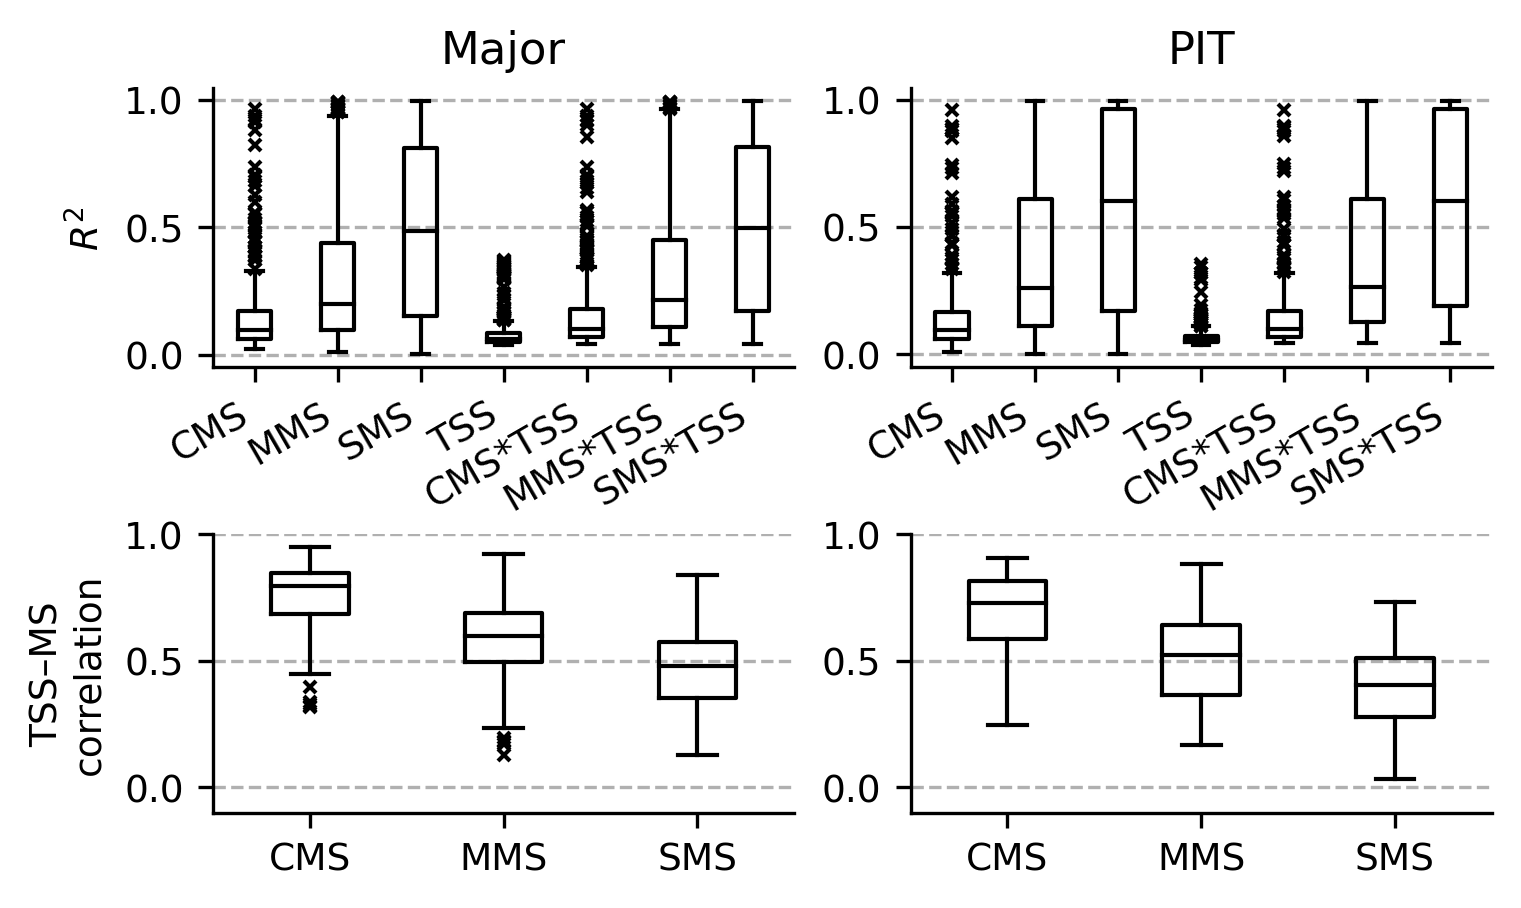

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 3.2,), dpi=300)
fig.subplots_adjust(hspace=0.6)

columns = ["CMS", "MMS", "SMS", "TSS", "CMS*TSS", "MMS*TSS", "SMS*TSS"]
titles = ["Major", "PIT"]
for idx, obj in enumerate([(major, major_cor,), (pit, pit_cor,)]):
    obj, cor = obj
    df = pd.DataFrame(obj)
    df.columns = columns
    ax = df.boxplot(showfliers=True, ax = axs[0, idx], medianprops=util.medianprops, widths=0.4, color=util.colorprops, boxprops=util.boxprops, flierprops=util.flierprops)
    ax.set_title(titles[idx])
    ax.set_yticks([0, 0.5, 1])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right")
    if idx == 0:
        ax.set_ylabel("$R^2$")
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().grid(False)
    ax.get_yaxis().grid(True, linestyle='--')

    cor.columns = ["CMS", "MMS", "SMS"]
    ax = cor.boxplot(ax=axs[1, idx], showfliers=True, medianprops=util.medianprops, widths=0.4, color=util.colorprops, boxprops=util.boxprops, flierprops=util.flierprops)
    ax.set_yticks([0, 0.5, 1])
    if idx == 0:
        ax.set_ylabel("TSS–MS\ncorrelation")

    ax.set_ylim(-0.1, 1)
    ax.get_xaxis().grid(False)
    ax.get_yaxis().grid(True, linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

plt.savefig('../seke/fig4.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()